In [ ]:
import logging

FORMAT = '%(levelname)s %(name)s %(filename)s:%(lineno)d\n%(message)s'
logging.basicConfig(format=FORMAT)
logging.getLogger().setLevel(logging.INFO)

In [1]:
import split_op as split
import numpy as np

def lennard_jones(x, d6, r6):
    r_pow6 = (r6 / x) ** 6
    return d6 * r_pow6 * (r_pow6 - 2)

mass = 6.0
energy = 1e-7
kelvin = 3.1668105e-6
momentum = np.sqrt(2 * mass * energy * kelvin)

grid = split.Grid.linear_continuos("x", 8.0, 20.0, 512, 0)

time_grid = split.TimeGrid(50.0, 1000, True)

array = np.zeros(grid.nodes_no(), dtype=complex)
points = grid.points()
for i in range(len(points)):
    array[i] = split.gaussian_distribution(points[i], 14.0, 2.0, momentum)
wave_function = split.WaveFunction(array, [grid])

r6 = 9.7
d6 = 0.0003
potential_array = np.zeros(grid.nodes_no())
for i in range(len(points)):
    potential_array[i] = lennard_jones(points[i], d6, r6)
potential_propagator = split.one_dim_into_propagator(potential_array, grid, time_grid)

kinetic_operator = split.kinetic_hamiltonian(grid, mass, energy)
kinetic_propagator = split.one_dim_into_propagator(kinetic_operator, grid, time_grid, step="full")

fft_transformation = split.FFTTransformation(grid, "momentum")

wave_saver = split.StateSaver("data/", "lj_ground", time_grid, grid, 120)
leak_control = split.LeakControl(split.LossChecker("leak control"))

operation_stack = split.OperationStack()
leak_control.add_operation(operation_stack)
wave_saver.add_operation(operation_stack)
potential_propagator.add_operation(operation_stack)
fft_transformation.add_operation(operation_stack, inverse_second=True)
kinetic_propagator.add_operation(operation_stack)

propagation = split.Propagation()
propagation.set_time_grid(time_grid)
propagation.set_wave_function(wave_function)
propagation.set_operation_stack(operation_stack)


propagation.propagate()
propagation.save_savers()

INFO split_op lib.rs:70
[1.05e-1+1.23e-6i, 1.07e-1+1.25e-6i, 1.09e-1+1.27e-6i, 1.11e-1+1.28e-6i, 1.13e-1+1.30e-6i, ..., 1.13e-1-1.30e-6i, 1.11e-1-1.28e-6i, 1.09e-1-1.27e-6i, 1.07e-1-1.25e-6i, 1.05e-1-1.23e-6i]


In [2]:
from matplotlib import animation
import numpy as np
import matplotlib.pyplot as plt

def wave_animation(prefix, grid_name, xlabel, with_potential=False): 
    wave = np.load(f'data/{prefix}.npy')
    grid = np.load(f'data/{prefix}_{grid_name}_grid.npy')

    if with_potential:
        potential = np.load(f'data/{prefix}_potential.npy')

    fig, ax = plt.subplots()

    def animate(i):
        ax.clear()
        ax.plot(grid, wave[:, i])
        if with_potential:
            ax.plot(grid, potential * np.max(wave[:, i]) / np.max(potential), color='black')
            
        ax.set_xlabel(xlabel)
        ax.set_ylabel("wave function density")

    anim = animation.FuncAnimation(fig, animate, interval=60, frames=wave.shape[1], blit=False)
    return anim

INFO matplotlib.animation animation.py:1060
Animation.save using <class 'matplotlib.animation.PillowWriter'>


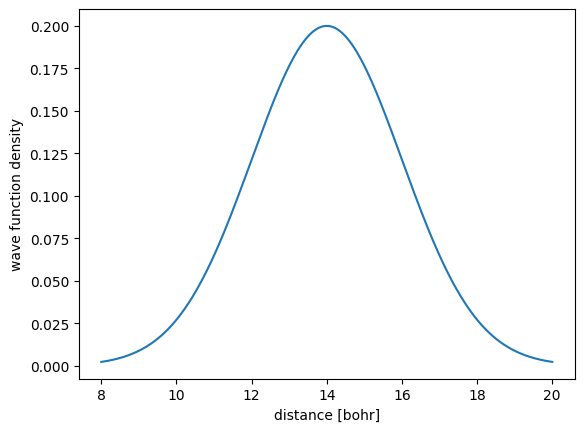

In [3]:
anim = wave_animation("lj_ground", "x", "distance [bohr]", False)
anim.save('plots/lj_ground_animation.gif', writer="pillow", fps=30)